# 0. Install dependencies

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [4]:
df = pd.read_csv(os.path.join('data/jigsaw-toxic-comment-classification-challenge', 'train.csv'))

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [13]:
df.iloc[15]['comment_text']

'"\n\nJuelz Santanas Age\n\nIn 2002, Juelz Santana was 18 years old, then came February 18th, which makes Juelz turn 19 making songs with The Diplomats. The third neff to be signed to Cam\'s label under Roc A Fella. In 2003, he was 20 years old coming out with his own singles ""Santana\'s Town"" and ""Down"". So yes, he is born in 1983. He really is, how could he be older then Lloyd Banks? And how could he be 22 when his birthday passed? The homie neff is 23 years old. 1983 - 2006 (Juelz death, god forbid if your thinking about that) equals 23. Go to your caculator and stop changing his year of birth. My god."'

In [11]:
# Getting all the column labels for 1 comment
df[df.columns[2:]].iloc[3]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 3, dtype: int64

In [14]:
# Listing all commetns labeleld as toxic
df[df['toxic']==1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [16]:
df[df.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

# 1. Preprocess

In [17]:
from tensorflow.keras.layers import TextVectorization

In [19]:
X = df['comment_text'] # comments
y = df[df.columns[2:]].values # labels

# 1.1 Tokenization

In [21]:
MAX_FEATURES = 200000 # number of words in the vocab

In [23]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                              output_sequence_length=1800, # sentence length of 1800 words max
                              output_mode='int')

In [24]:
vectorizer.adapt(X.values) # learns all words in the dataset in a numpy array

In [27]:
# testing vectorizer
vectorizer('Hello world')

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([286, 261,   0, ...,   0,   0,   0], dtype=int64)>

In [28]:
TextVectorization?? # lowers and strips by default

Init signature:
TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    **kwargs,
)
Source:        
@keras_export(
    "keras.layers.TextVectorization",
    "keras.layers.experimental.preprocessing.TextVectorization",
    v1=[])
class TextVectorization(base_preprocessing_layer.PreprocessingLayer):
  """A preprocessing layer which maps text features to integer sequences.

  This layer has basic options for managing text in a Keras model. It transforms
  a batch of strings (one example = one string) into either a list of token
  indices (one example = 1D tensor of integer token indices) or a dense
  representation (one example = 1D tensor of float values representing data
  about the example's tokens). This layer is meant to handle natural language
  i

In [29]:
# PAss all x data through the vecctorizer
vectorized_text = vectorizer(X.values)

In [30]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  643,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2506, ...,     0,     0,     0],
       [  425,   440,    70, ...,     0,     0,     0],
       ...,
       [32141,  7329,   383, ...,     0,     0,     0],
       [    5,    12,   533, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [31]:
len(X)

159571

## 1.2 Creating the dataset

In [34]:
# MCShBaP - map, cache, shuffle, batch, prefetch
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y)) # input features, target labels
dataset = dataset.cache()
dataset = dataset.shuffle(160000) # greater than len(X)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps prevent bottlenecks

In [36]:
batch_X, batch_y = dataset.as_numpy_iterator().next() # unpacked data and label pair 
batch_X.shape, batch_y.shape

((16, 1800), (16, 6))

In [38]:
len(dataset) # number of batches of 16

9974

In [39]:
train = dataset.take(int(len(dataset)*.7)) # 70% train
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2)) # 20% val
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1)) # 10% test

In [41]:
train_generator = train.as_numpy_iterator()

In [46]:
train_generator.next() # how the model gets the next value in the dataset

(array([[    8,    44,   390, ...,     0,     0,     0],
        [ 7407, 20754,    15, ...,     0,     0,     0],
        [  311,   296,   954, ...,     0,     0,     0],
        ...,
        [    2,   370, 34190, ...,     0,     0,     0],
        [  265,     1,     8, ...,     0,     0,     0],
        [90806,     8,    19, ...,     0,     0,     0]], dtype=int64),
 array([[1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

# 2. Create Sequential Model

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Embedding, Dense

In [56]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32)) # +1 for unknown words, 32 values in length
# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(32, activation='tanh'))) # tanh is required for LSTM layer when using GPU acceleration
# Feature Extraction FC layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Output with 6 outputs (length of labels y)
model.add(Dense(6, activation='sigmoid')) # values output between 0 and 1

In [57]:
model.compile(loss='BinaryCrossentropy', # not categoricalcrossentropy since we are essentially running 6 binary models (multi-output model) 
            optimizer='Adam')

In [58]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 6)                 774       
                                                      

In [148]:
history = model.fit(train,
                   epochs=10,
                   validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 865s 123ms/step - loss: 0.0472 - val_loss: 0.0425
Epoch 2/10
6981/6981 [==============================] - 863s 124ms/step - loss: 0.0415 - val_loss: 0.0371
Epoch 3/10
6981/6981 [==============================] - 868s 124ms/step - loss: 0.0373 - val_loss: 0.0329
Epoch 4/10
6981/6981 [==============================] - 856s 123ms/step - loss: 0.0330 - val_loss: 0.0301
Epoch 5/10
6981/6981 [==============================] - 878s 126ms/step - loss: 0.0295 - val_loss: 0.0258
Epoch 6/10
6981/6981 [==============================] - 908s 130ms/step - loss: 0.0265 - val_loss: 0.0225
Epoch 7/10
6981/6981 [==============================] - 909s 130ms/step - loss: 0.0239 - val_loss: 0.0211
Epoch 8/10
6981/6981 [==============================] - 914s 131ms/step - loss: 0.0215 - val_loss: 0.0187
Epoch 9/10
6981/6981 [==============================] - 904s 130ms/step - loss: 0.0192 - val_loss: 0.0157
Epoch 10/10
6981/6981 [=======================

In [149]:
import matplotlib.pyplot as plt

In [150]:
history.history

{'loss': [0.047242920845746994,
  0.04147062078118324,
  0.03727998211979866,
  0.03300211951136589,
  0.029476525261998177,
  0.026543183252215385,
  0.02386424131691456,
  0.02153678983449936,
  0.019191894680261612,
  0.01723581925034523],
 'val_loss': [0.042483940720558167,
  0.0370505228638649,
  0.03290226310491562,
  0.03006216138601303,
  0.025836391374468803,
  0.02245575562119484,
  0.021112671121954918,
  0.018745625391602516,
  0.015729114413261414,
  0.014555360190570354]}

<Figure size 800x500 with 0 Axes>

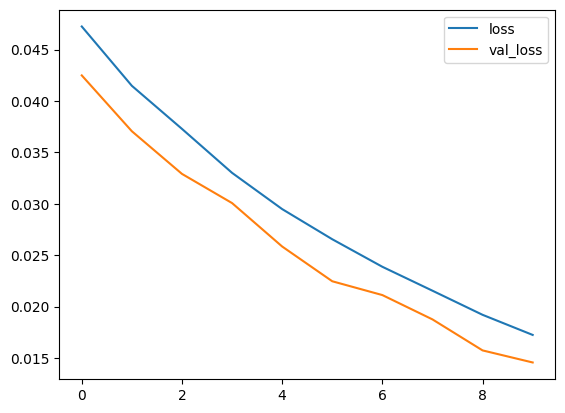

In [151]:
# Plotting history (only have 1 epoch so wont display anything)
plt.figure(figsize=(8, 5))
pd.DataFrame(history.history).plot()
plt.show();

# 3. Make predictions

Prediction text needs to be tokenized and batched first before entering the model

In [152]:
input_text = vectorizer('You freaking suck!')

In [153]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [154]:
# Getting the prediction results for each of the columns on the test dataset
model.predict(np.expand_dims(input_text, 0))

array([[0.9997433 , 0.1354193 , 0.9883477 , 0.00627956, 0.92309344,
        0.01430006]], dtype=float32)

In [155]:
batch = test.as_numpy_iterator().next()

In [156]:
# Can do predictions on whole batches of the dataset
batch_X, batch_y = test.as_numpy_iterator().next()

In [157]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [158]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [159]:
res = model.predict(batch_X)

# 4. Evaluate model

In [160]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [161]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [162]:
# Loop every batch in the pipeline
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [163]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9244762659072876, Recall:0.9237124919891357, Accuracy:0.5165496468544006


# 5. Test and Gradio

In [116]:
!pip install gradio jinja2

                                              0.0/19.7 MB ? eta -:--:--
                                              0.2/19.7 MB 4.0 MB/s eta 0:00:05
     ---                                      1.7/19.7 MB 18.1 MB/s eta 0:00:01
     ----------                               5.2/19.7 MB 36.9 MB/s eta 0:00:01
     -----------------                        8.7/19.7 MB 46.6 MB/s eta 0:00:01
     ------------------------                12.2/19.7 MB 72.6 MB/s eta 0:00:01
     -------------------------------         15.9/19.7 MB 72.6 MB/s eta 0:00:01
     --------------------------------------  19.5/19.7 MB 72.6 MB/s eta 0:00:01
     --------------------------------------  19.7/19.7 MB 72.6 MB/s eta 0:00:01
     --------------------------------------- 19.7/19.7 MB 59.5 MB/s eta 0:00:00
                                              0.0/133.1 kB ? eta -:--:--
     -------------------------------------- 133.1/133.1 kB 7.7 MB/s eta 0:00:00
                                              0.0/319.8 

In [125]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [126]:
import gradio as gr

In [164]:
model.save('models/toxicity.h5')

In [165]:
model = tf.keras.models.load_model('models/toxicity.h5')

In [166]:
input_str = vectorizer('You freaking suck!')

In [167]:
res = model.predict(np.expand_dims(input_str, 0))

In [168]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [169]:
res

array([[0.9997433 , 0.1354193 , 0.9883477 , 0.00627956, 0.92309344,
        0.01430006]], dtype=float32)

In [170]:
# Function to add to gradio model
def score_comment(comment):
    # convert text into sequence of numbers
    vectorized_comment = vectorizer([comment])
    # predict using the model
    results = model.predict(vectorized_comment)
    
    text = ''
    # Loop through every column and unpack results
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5) # take each index and say if > 0.5, print column and if is true
        
    return text

In [171]:
# Creating Gradio interface
interface = gr.Interface(fn=score_comment,
                        inputs=gr.components.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [172]:
interface.launch(share=True) # share=True makes app public

Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app. 

Also please ensure that your antivirus or firewall is not blocking the binary file located at: D:\Machine Learning\Comment_Toxicity\NLP\lib\site-packages\gradio\frpc_windows_amd64_v0.2
